In [1]:
#import dependencies library

# the enviornment library
import gym

#the AI framework 
import tensorflow as tf
import tensorflow.keras as keras 
import numpy as np

#just for ploting stuf
import cv2
import matplotlib.pyplot as plt
import tqdm

from collections import deque

In [ ]:
import urllib.request
urllib.request.urlretrieve('http://www.atarimania.com/roms/Roms.rar','Roms.rar')
!pip install unrar
!unrar x Roms.rar
!mkdir rars
!mv HC\ ROMS.zip   rars
!mv ROMS.zip  rars
!python -m atari_py.import_roms rars


After we import dependecies we will creat our enviornment using **gym** library and we chose the brakout game as the playground game to worke on.

In [3]:
# make the environment we chose breakout game to try on.
environment=gym.make("Breakout-v4")

lets explore the environment 

In [4]:
print(environment.unwrapped.get_action_meanings())

['NOOP', 'FIRE', 'RIGHT', 'LEFT']


In [5]:
# the actions space represent the output of the Neural Network 
action_space=environment.action_space.n
print("The number of action is :({}) and which is the number of output of Neural Network".format(action_space))

The number of action is :(4) and which is the number of output of Neural Network


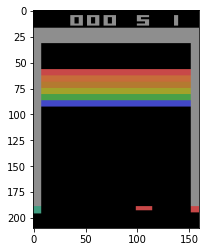

In [6]:
state=environment.reset()
plt.imshow(state)

The First step is make some preprocessing to each frame, where want change the **RGB** format to **gray** fromat and that decrease the confusing in the network and we will cut the top of frame which represent the reword which change and may confuse the training process.

In [7]:
class FireResetEnv(gym.Wrapper):
    """
    This class is Warpper where we make sure that the game is runing, becouse in some environment in gym library should 
    start the game by action " 1 " in most of the game so by doing this we make sure that the game is roling.
    """
    def __init__(self, env=None):
        super(FireResetEnv, self).__init__(env)
        assert env.unwrapped.get_action_meanings()[1] == 'FIRE'
        assert len(env.unwrapped.get_action_meanings()) >= 3
        
    def step(self, action):
        return self.env.step(action)
    
    def reset(self):
        self.env.reset()
        obs, _, done, _ = self.env.step(1)
        if done:
            self.env.reset()
            obs, _, done, _ = self.env.step(2)
            if done:
                self.env.reset()
        return obs

In [8]:
env=FireResetEnv(environment)

In [9]:
#this model is as recomende from paper "Mnih et al., 2015; van Hasselt et al., 2015"
keras.backend.clear_session()

model=keras.Sequential([
    keras.layers.Conv2D(32,8,strides=4,padding='valid',activation='relu',input_shape=[84,84,4]),
    keras.layers.Conv2D(64,4,strides=2,padding='valid',activation='relu'),
    keras.layers.Conv2D(64,3,strides=1,padding='valid',activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(512,activation='relu'),
    keras.layers.Dense(action_space)
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 20, 20, 32)        8224      
                                                                 
 conv2d_1 (Conv2D)           (None, 9, 9, 64)          32832     
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 64)          36928     
                                                                 
 flatten (Flatten)           (None, 3136)              0         
                                                                 
 dense (Dense)               (None, 512)               1606144   
                                                                 
 dense_1 (Dense)             (None, 4)                 2052      
                                                                 
Total params: 1,686,180
Trainable params: 1,686,180
Non-

In this Notebook we will implement Double DQN with proportional prioritization from **[Schaul etc,, 2016](link)** as it's outperforms the DDQN with uniform propabiltiy for transition in the replay buffer.

*Experience replay* as we show in previous lecture that if we using replay buffer that break the temporal correlations by mixing more and less recent experience for the updates, and rare experience will be used for more than just a single update.
This was demonstrated in the Deep Q-Network (DQN) algorithm (Mnih et al., 2013; 2015), which
stabilized the training of a value function, represented by a deep neural network, by using experience
replay

More specifically, experiences are considered **important** if they are likely to lead to
fast learning progress,While this measure is not directly accessible,a reasonable proxy is the **magnitude of a transition’s TD error δ**, which indicates how **surprising** or **unexpected** the transition is: specifically, how far the value is from its next-step bootstrap estimate.

so this idea it's almost the same as boosting where we creat a new classifire for the examples we get them wrong and train on thouse miss predict examples, but this may lead to over-fit becouse we train on some examples more than other.

so as boosting this will happen for **greedy TD-error** First, to avoid expensive sweeps over
the entire replay memory, TD errors are only updated for the transitions that are replayed. One
consequence is that transitions that have a low TD error on first visit may not be replayed for a long time.
Finally, greedy prioritization focuses on a
small subset of the experience: errors shrink slowly, especially when using function approximation,
meaning that the initially high error transitions get replayed frequently. This lack of diversity that
makes the system prone to over-fitting.

To overcome these issues, we introduce a **stochastic sampling** method that interpolates between
pure **greedy prioritization** and **uniform random sampling**. We ensure that the probability of being
sampled is monotonic in a transition’s priority, while guaranteeing a non-zero probability even for
the lowest-priority transition. Concretely, we define the probability of sampling transition i as

$P(i) = \frac{p_i^\alpha}{\sum_k p^\alpha}$

where $p_i > 0 $ is the priority of transition i. The exponent $ α $ determines how much prioritization is
used, with $α = 0$ corresponding to the uniform case. 
so $α$ become another hyperparameter we need to tune but for atari game as the Author of the paper find $α = 0.6$
is the best for this problem but for other problem we should tune it's value for the best approximation. 
**<p style="color:red;">Important Note:</p>**
$p_i > 0 $ is the **TD-error** which is from the Definition $[R_j+ \gamma_j Q(s_{j+1},argmax_a Q(s_{j+1},a),\theta^-)-Q(s_j,a_j,\theta^+)]$

but we will use the erorr form the Neural Network which is the squred of the **TD-erorr** becouse the target of our model is $[R_j+ \gamma_j Q(s_{j+1},argmax_a Q(s_{j+1},a),\theta^-)]$ and that is the same as before without the last tearm which is the output of the model, we add small positive constant $\epsilon$ that prevents the edge-case of transitions not being revisited once their error is zero


Now after we prioritized the transition, the transition with Hight priority will be sampled more often until the erorr of this transition go down and that may laid to over-fit.

We can correct this bias by using importance-sampling (IS) weights

$w_i=(N*P(i))^-\beta$

where $N$ is the Number of samples in the memory and $P(i)$ is the probability of transition $i$

$β$ is a hyperparameter that controls how much we want to compensate for the importance sampling bias (0 means not at
all, while 1 means entirely). In the paper, the authors used $β = 0.4$ at the beginning of
training and linearly increased it to β = 1 by the end of training. Again, the optimal value will depend on the task

after we highlight the important point of the algorithm lets start the implementation.

## First: The Sum-Tree:

The **sum-tree** data structure used here is very similar in spirit to the
array representation of a binary heap. However, instead of the usual heap property, the value of
a parent node is the sum of its children. Leaf nodes store the transition priorities and the internal
nodes are intermediate sums, with the parent node containing the sum over all priorities, $p_{total}$ . This
provides a efficient way of calculating the cumulative sum of priorities, allowing O(log N ) updates
and sampling. To sample a minibatch of size k, the range $[0, p_{total}]$ is divided equally into k ranges.

Next, a value is uniformly sampled from each range. Finally the transitions that correspond to each
of these sampled values are retrieved from the tree

beside this structure we will add other proberty rolling data structure, whene the data full it's rolling to the first element and overwrite it.

a good article explaine the Sum Tree : [Introduction to Sum Tree](https://www.fcodelabs.com/2019/03/18/Sum-Tree-Introduction/)

In [10]:
import numpy as np
import tensorflow as tf

class SumTree:
    """
    This class is implementation to Sum Tree data structure this data structure is compleat binary Tree 
    and is the same as Priority Qeue where the root node contain the sum of all leaf node in the Tree 
    using this data structure reduce the update time to O(log(n)) and find the sum to O(1).
    The root node have index = 1 and keep the 0 index unuse and that for make the left children is 2*parent_index and that just for simplicity.
    we implement this data structure for using in Proportional Prioritization in the Prioritized Experience Replay from deepmid
    
    Attributes: 
       size : represent the size of buffer 
       tree : it's the binary Tree use to the priority which need to get the sum and update.
       data : where we save the information 
       current_pos: is the pointer to the current postion of the data 
       n_entries : number of information we have.
       max_prio :  this is not relate to the Sum Tree but we need to trake the Max priority for using in our algorithm
                   and by doing this we reduce the time to O(1)
    method :
        -add : using this method to add transition to data list and priority to the tree and updat the tree by 'Bubbel up' as the Priority Qeue 
        -update :  just like 'Bubbel up' where add the priority to empty slot in the tree and then update it's parent until we rich the root node.
        -total  : return the root value which is the sum of all leaves in the tree
        -get_sample : travers in tree to find the priority and the data linked to that priority.
    """
    def __init__(self,buffer_size):
        self.size=buffer_size
        self.tree=[0]*2*buffer_size
        self.data=[]
        self.current_pos=0
        self.n_entries=0
        self.max_prio=1
    
    def add(self,transition,priority):
        """
        in This function we add a new data to the tree 
        parameter: 
            transition: is data we will save it 
            priority : is the value we add to the tree and then update the sum over the whole tree.
        return :
            None, working inplace.
        """
        if self.n_entries<self.size:    
            self.n_entries += 1
            self.data.append(transition)
            
            self.current_pos = (self.current_pos + 1) % self.size
            
            node_index=self.current_pos + self.size
            
            
            self.update(node_index,priority)
            
        else:
            self.data[self.current_pos]=transition
            
            node_index=self.current_pos + self.size
        
            self.update(node_index,priority)
        
            self.current_pos = (self.current_pos + 1) % self.size
        
            
    def total(self):
        """
        This function return the sum of all leaves in the tree which is root node
        """
        return self.tree[1]
    
    def update(self,node,priority):
        """
        This function update the nodes in the tree adter we add new node or update a value of exist node 
        parameter :
            -node : is the index of node we want to update it's value which is leave
            -priority : is the value to add to tree
        """
        
        self.max_prio=max(self.max_prio,priority)
        
        different=priority-self.tree[node]
        
        self.tree[node] = priority
        
        parent = node // 2
        
        self.tree[parent] += different
        
        while parent !=1:
            parent =parent // 2
            self.tree[parent] += different
    
    
    def _retrieve(self,index,random_value):
        """
        This function is for find the right value in the tree after we provide a random value 
        """
        left_chield = 2*index
        right_chield= 2*index + 1
        
        if left_chield >= 2*self.size:
            return index
        
        if self.tree[left_chield]>=random_value:
            return self._retrieve(left_chield,random_value)
        else :
            return self._retrieve(right_chield,random_value-self.tree[left_chield])
    
    def get_sample(self,random_value):
        """
        In this function we travers the whole tree from the root node to the bottom of the tree using the retrieve method 
        """
        index=self._retrieve(0,random_value)
        
        priority=self.tree[index]
        
        data_index=index-self.size-1
        try:
            transition=self.data[data_index]
        except:
            print("The error happen hear :",data_index)
            print("The index is :",index)
            print("Priority :",priority)
        return (transition,priority,index)

## Secand: Memory
Now we will implement the The Memory class that depend on the Sum Tree data structure which the replay buffer.
the replay buffer now is SumTree with some other functions the most important one is **sample experiances** function 
in this function we sample the data from the memory as we explaine a bove we also calculate the sample weights as in Equation $w_i=(N*P(i))^-\beta$ 


In [11]:
class Memory:
    """
    This class is used to creat our replay buffer to use in the *Prioritized Experience Replay* 
    
    Attributes:
        -size : the replay buffer size.
        -tree : is the Sum Tree data structure .
        -alpha : the parameter using in the the stochastic probability priority=(p_i+epsilon)**alpha 
        -epsilon :  is positive small value added to the error 
        -beta : is the prameter used to calculate the weigths
        -BETA_0 : is the statrting value of the beta 
        -BETA_FRAMS : is used for update the beta factor during the training.
    
    method:
        -add : used to add data to the tree.
        -sample_experiences : this function is used to sample experiences from the tree
        -update : update the priority in the tree after training one batch of data
    """
    BETA_0=0.4
    BETA_FRAMES=1e7
    
    def __init__(self,size):
        self.size=size
        self.tree=SumTree(size)
        self.alpha=0.6
        self.epsilon=1e-5
        self.beta=0.4
    
    def _update_beta(self):
        """
        This function update the beta parameter from 0.4 to 1 after 1e7 frame 
        """
        tmp=self.beta+(1-self.BETA_0)/self.BETA_FRAMES
        self.beta=min(1,tmp)
        
        
    def add(self,transition):
        """
        this function add a new data to the memory with priority= max pi 
        and that is the reson, we keep track of the Max priority in the Sum Tree class
        
        parameter :
            -transition : is the data we add (state, action ,reward, done ,next_state ) we add this record to the Tree with 
                          max priority , and that ensure that, this transition will train on it at least once.
        """
        priority=self.tree.max_prio
        self.tree.add(transition,priority)
        
    def sample_experiences(self,batch_size):
        """
        This function used to sample data from the memory 
        parameter :
            - batch_size :  the number of training example we will use for training.
        return :
            - batch : is the data we sample from the memory list with shape [batch_size,1] where each value is (state,action,reward,done,next_state)
            - weights : is the importance sampling (IS) weights 
            - indices :  the index of each training example used for train for used later in update the priority in the Tree.
        """
        batch_data=[]
        indecis=[]
        priorites=[]
        p_total=self.tree.total()
        segment=p_total/batch_size
        self._update_beta()
        for i in range(batch_size):
            low = segment * i
            hight = segment * (i + 1)
            
            value =np.random.uniform(low, hight)
            
            transition,priority,index=self.tree.get_sample(value)
            batch_data.append(transition)
            indecis.append(index)
            priorites.append(priority)
            
        priorites=np.array(priorites)/p_total
        
        weights=np.power(self.tree.n_entries*priorites,-self.beta)
        weights /= np.max(weights)
        
        return (batch_data,weights,indecis)
        
    def update(self,indices,errors):
        """
        This function receive the errors from the model and calculate the priority then calls the update function 
        from the Sum Tree opject on each node used for training.
        parameter : 
            - indices : the index of each training example used for train.
            -error : is the error for each transition used in training model.
 
        """
        priorites=(np.abs(errors)+self.epsilon)**self.alpha
        for index,priority in zip(indices,priorites):
            self.tree.update(index,priority)

In [13]:
#----->  The name of the class we change from The Double_DQN to Agent I am just Kiding...

class Agent:
    def __init__(self,environment,model,discount_factor=0.95,learning_rate=0.00025/4,episode=10000,batch_size=32,replay_size=1000000,staked_frame=4,fixed_epsilon=None,model_checkpoint='DQN_wights_with_PrioritizedReplay.h5',up=25,down=10,left=5,right=5,update_steps=50):
        #the environment simulator 
        self.env=environment
        # hear we made the first change where we have 2 model instead of one model the online_model and target_model 
        #  the first one it's using for compute Q_value function at each time step while the other to just compute the target.
        self.online_model=model
        # the second model is the target model have the same structure of the online model and the same inial parameter.
        self.target_model=keras.models.clone_model(model)
        self.target_model.set_weights(model.get_weights())
        # the discout factor in the Q-learning algorithem
        self.discount_factor=discount_factor
        # the number of episod to run as the number of epochs in supervised learning 
        self.episodes=episode
        # onather update to the previouse alogorithem where we need parameter that difine the update rate for the target model.
        self.update_rate=update_steps
    
        self.batch_size=batch_size
#---->  the memory where we save the observations for training we now use our memory.
        self.replay_buffer=Memory(replay_size)
        # the deque used for state creation where we stacked last 4 frames togather 
        self.stacked_blocks=deque(maxlen=staked_frame)
        # if we want to stack more or less frame togather in other world if we want the state more complex or simpler.
        self.stacked_size=staked_frame
        # if we want the epsilon parameter constant during the training else the parameter will change during the training.
        self.fixed_epsilon=fixed_epsilon
        # the action space it's represent the number neuron in the output layer becouse Q function is maping from state to actions. 
        self.action_space=environment.action_space.n
        # it's rewards list where we save the reward from each episod ( from each epochs )
        self.rewards_list=[]
        # the loss function using to compute the gradiant of the model.
        self.loss_function=tf.losses.mean_squared_error
        # the optimizer using to update the parameter.
        self.optimizer=tf.optimizers.RMSprop(learning_rate=learning_rate,momentum=0.95)
        # it's the file path, where we save the model weights
        self.model_checkpoint=model_checkpoint
        # these four parameter we use for croping the edges of the frame  
        self.up=up
        self.down=-down
        self.left=left
        self.right=-right
    
    def _preprocess_frame(self,frame):
        """
        this function make preprocessing step for each frame from the game.
        parameter: 
            -frame: is a row frame with [210*64*3] size which provided by the environment, after we make an action that change the world
            the environmnt brovide us by new observation after apply that action.
        return :
            image: processing frame where we cut some of border and keep the play area and change the image to gray scale 
            then resize it to [84,84] shape and finaly normalize pixel value to become in the range [0-1] 
        """
        # cut the porder and keep the play area
        image=frame[self.up:self.down,self.left:self.right,:]
        image=tf.image.rgb_to_grayscale(image)
        image=tf.image.resize(image,[84,84])
        # reshape becouse it's tensor [84,84,1] and we want [84,84] for make the stacking operation easy
        image=tf.reshape(image,[84,84])
        # normalizing step
        image=image/255.0
        return image
    
    def ploting_function_one(frame):
        """
        is the same as preprocessing function but we use it for viualization stuf.
        """
        image=frame[25:,:,:]
        image=cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
        image=cv2.resize(image,(85,85))
        return image
    
    
    def _state_creator(self,frame,is_new_episod):
        """
        this function we stack last 4 frame togather to perform on state and that give us some intuition about vilocity.
        parameter :
            -frame :which is the game observation.
            -is_new_episod: boolean parameter that check if there is no previous frame and that happend in bragning of each episod.
        
        return :
            state: tensor with [84,84,4] shape which represent the state of our world.
        """
        # first preprocessing the frame.
        image=self._preprocess_frame(frame)
        # if it's new episod then stack the first frame four time 
        if is_new_episod:
            for i in range(self.stacked_size):
                self.stacked_blocks.append(image)
                
        # just push the last frame so the first frame get out from the deque
        else:
            self.stacked_blocks.append(image)
            
        # stacked the frames togather in one tensor [84,84,4]
        state=tf.stack(self.stacked_blocks,axis=2)
        
        return state
    
    def _sample_experiences(self):
        """
        This function is use to sample batch from our memory.
        
        return:
            -states:it's tensore [batch_size,image_width,image_height,stacked_size] in our case [32,84,84,4]
            -actions: it's 2D array [batch_size,action] it's the action in each state in our batch
            -rewards: it's 2D array [batch_size,reward] it's the reward in each state in out batch
            -dones : it's 2D array [batch_size, done ] where done is boolean value help us to compute the target.
            -next_state: it's tensore [batch_size,image_width,image_height,stacked_size] in our case [32,84,84,4]
        """
#---->  instead of using random choice to select transition we use the prioritized memory object to sample data.
        batch,weights,indices=self.replay_buffer.sample_experiences(self.batch_size)
        # we combine the experiance togather where the buffer have tuple like this (state,action,reward,done,next_state)
        states,actions,rewords,dones,next_states=[np.array([experiance[field_index] for experiance in batch]) for field_index in range(5)]
#---->  we return the weights and inices becouse we need them for training step. 
        return states,actions,rewords,dones,next_states,weights,indices
    
    
    def _epsilon_greedy_policy(self,state,epsilon):
        """
        Is the epislon greedy policy whre we use epsilon value to chose an action
        where we want to palance the exploration and explotation as possiable as we can.
    
        we pick random value alpha.
            -if alpha < epsilon : chose random action
             else argmax Q(state) for all action.
        parameter :
            -state: is the current state.
            -epsilon : is the value of threshould between [0,1]
        return :
            the number of action to make 
    
        """
        if np.random.rand()<epsilon:
            return np.random.randint(self.action_space)
        else:
            # hear we use the online model for prediction of best action.
            Q_values=self.online_model.predict(state[np.newaxis])
            return tf.argmax(Q_values[0])
    
    def _play_one_step(self,state,epsilon):
        """
        This function make an action and get the observation from the world.
        we make an action and then get the full obesrvation from our environment aplay state_create function to the our 
        observation(frame) and then save it in the memory for training step.
    
        parameter :
            -state : it's the current state.
            -epsilon: it's the thresould we use for action selection
        return :
            next_state: tensore [84,84,4] block represent the last 4 frame.
            reward : it's float number the reward we get after we do some action . 
            done : it's boolean refer if the game finish or not 
            info : it's dictionary have the counter of lives.
        """
          
        action=self._epsilon_greedy_policy(state,epsilon)
        next_state,reward,done,info=self.env.step(action)
        # we do that becouse we need True done value for computing the target for the model.
        if info['ale.lives']< 5:
            done=True
        stacked_next_state=self._state_creator(next_state,False)
#---->  hear we change the append function to the add function related to the Memory object         
        self.replay_buffer.add((state,action,reward,done,stacked_next_state))
        return stacked_next_state,reward,done,info
    
    def _training_step(self):
        """
        This function is the responsible for doing one training step where we sample one batch from the replay buffer 
        then we push this batch in our model for forward step and apply gradiant with optimizer by hand.
        
        return :
            None , where it's apply the change inplace for model parameter.
        """
#---->  get the batch from the replay_buffer (our memory) with weights and indices.
        states,actions,rewards,dones,next_states,weights,indices=self._sample_experiences()
        # the online_Q(state,a)=online_Q(state,a) + alpha [ reward + gamma * target_Q(next_state,argmax online_Q(next_state,a_i) for all a)-online_Q(state,a)] 
        # as we can see hear we replace the prediction from the target model to online model as "Hado van Hasselt 2015" recomend 
        next_Q_values=self.online_model.predict(next_states)
        # hear we take the best action over all action for the whole batch     
        max_next_Q_values=np.argmax(next_Q_values,axis=1)
        # create mask for reducing the value of actions that we don't used.        
        next_mask = tf.one_hot(max_next_Q_values, self.action_space).numpy()

        # compute the target which is [reward +  gamma * target_Q(next_state,argmx online_Q(next_state,a) over a) ]    
        max_next_Q_values=(self.target_model.predict(next_states) * next_mask).sum(axis=1)
        target_Q_values=rewards+(1-dones)*self.discount_factor*max_next_Q_values
        
        #this mask it's important for vanishing the value of actions that we don't used it's 2D array with 1 if action i was picked and zero othewise.
        mask = tf.one_hot(actions, self.action_space)

        #start the gradient recording to compute the gradient for our model.
        with tf.GradientTape() as tape:
            # compute the Q function for current state (hear for the whole batch).
            all_Q_values=self.online_model(states)
            #hear we use the mask so we reduce the result for just the action we picked.
            Q_values=tf.reduce_sum(all_Q_values*mask,axis=1,keepdims=True)
#----->     computer the loss function with the target we compute erlaier, these losses will be the new Priority .
            losses=self.loss_function(target_Q_values,Q_values)
#----->     computer the wighted loss then reduce to the mean so we can compute the gradeint             
#----->     There is an Extenstion to this algorithm as the author of the paper suggest, that the new priority p_i=loss_i
#----->     can be loss*weights so p_i=loss_i*weights_i then using the stochastic probability.
#----->     it's so simple to modife the code for the extenstion but i will keep it as the peudocode in the paper.
            loss = tf.reduce_mean(losses * weights)
            
        # compute the gradient for our  online_model parameter.
        gradiants=tape.gradient(loss,self.online_model.trainable_variables)
        # apply the optimization step using the gradient we compute for the online_model
        self.optimizer.apply_gradients(zip(gradiants,self.online_model.trainable_variables))
#---->  onther change where we update the priority of the transition we use in the training step.      
        self.replay_buffer.update(indices,losses)
        
    def fit(self):
        """
        This function represent the training loop function where we are trying to fit model to produce the best function
        according to the data we have.
        
        """
        for episode in tqdm.tqdm(range(self.episodes)):
            state=self.env.reset()
            stacked_state=self._state_creator(state,True)
            rewards=0
            epsilon=max(1-episode/5000,0.1)
            # using this parameter to update the model parameter each 4 step .
            minibatch_uppdate=0
            while True:
                stacked_state,reward,done,info=self._play_one_step(stacked_state,epsilon)
                minibatch_uppdate += 1
                rewards+=reward
                if done :
                    if not (episode%10) and len(self.rewards_list):
                        self.online_model.save_weights(self.model_checkpoint)
                        print("The best score for last 10 episode is: {} and the worst one is: {}".format(max(self.rewards_list[-10:]),min(self.rewards_list[-10:])))
                    self.rewards_list.append(rewards)
                    break
                # this step to let the replay buffer has some experiance
                if episode>50:
                    self._training_step()
                #hear we update the target model after 50 episod by set it parameter as the online model.
                if episode%self.update_rate:
                    self.target_model.set_weights(self.online_model.get_weights())

In [14]:
agent=Agent(env,model)

In [ ]:
agent.fit()